# Harris County Home Price Estimations

In [1]:
import sqlite3

import pandas as pd
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
con = sqlite3.connect('HouseProtestValues.db')

sql_query = '''SELECT  br.acct,
                       br.bld_num,
                       br.date_erected,
                       br.yr_remodel,
                       br.im_sq_ft,
                       br.gross_ar,
                       br.base_ar,
                       ra.land_ar,
                       br.perimeter,
                       br.size_index,
                       ra.land_val,
                       ra.bld_val,
                       ra.assessed_val,
                       ra.tot_appr_val,
                       ra.tot_mkt_val
            FROM building_res as br
            LEFT JOIN real_acct as ra ON br.acct = ra.acct
            WHERE br.impr_tp = 1001 AND br.property_use_cd = 'A1' AND br.date_erected > 10;'''

building_data = pd.read_sql_query(sql_query, con)

In [3]:
# Story Height Index: STY
# Room: Bedroom: RMB
# Room: Full Bath: RMF
# Room: Half Bath: RMH
# Room: Total: RMT
fixtures_sql = """SELECT *
                  FROM "fixtures"
                  WHERE type IN ('STY', 'RMB','RMF','RMH','RMT')
                """
fixtures = pd.read_sql_query(fixtures_sql, con)
fix_pt = fixtures.pivot_table(index=['acct', 'bld_num'], columns='type', values='units', aggfunc='sum')
fix_pt = fix_pt.reset_index()
fix_pt.fillna(0, inplace=True)

In [4]:
all_df = pd.merge(building_data, fix_pt, on=['acct', 'bld_num'], how='left')
all_df.dropna(inplace=True)

In [5]:
all_df.tail()

,acct,bld_num,date_erected,yr_remodel,im_sq_ft,gross_ar,base_ar,land_ar,perimeter,size_index,land_val,bld_val,assessed_val,tot_appr_val,tot_mkt_val,RMB,RMF,RMH,RMT,STY
1122301,1938003804013,1,2003,0,2117,2553,2117,5250,318,0.84,35438.0,233603.0,269041.0,269041.0,269041.0,3.0,2.0,1.0,7.0,2.0
1122302,1938003804014,1,2003,0,1611,2254,1611,5250,184,0.89,35438.0,204053.0,239491.0,166883.0,239491.0,3.0,2.0,0.0,6.0,1.0
1122303,1953050320690,1,1979,0,2168,2700,2168,6820,232,0.84,54560.0,201010.0,255570.0,240372.0,255570.0,3.0,2.0,0.0,5.0,1.0
1122304,1953080320060,1,1983,0,1723,2259,1723,7575,216,0.88,55740.0,173156.0,228896.0,228896.0,228896.0,3.0,2.0,0.0,6.0,1.0
1122305,1955020050280,1,1979,0,1374,2047,1374,8851,250,0.94,64580.0,160896.0,225476.0,216585.0,225476.0,3.0,2.0,1.0,5.0,2.0


In [6]:
sample_df = all_df.sample(n=1000)

x = sample_df[['date_erected', 'yr_remodel', 'im_sq_ft',
               'gross_ar', 'base_ar', 'land_ar', 'perimeter', 'size_index',
               'RMB', 'RMF', 'RMH', 'RMT', 'STY']]
y = sample_df['assessed_val']

In [7]:
print(f"All Data{sample_df.shape} | x {x.shape} | y {y.shape}")

All Data(1000, 20) | x (1000, 13) | y (1000,)


In [8]:
# Free up memory
building_data = None
fix_pt = None
fixtures = None


<Axes: xlabel='assessed_val', ylabel='Count'>

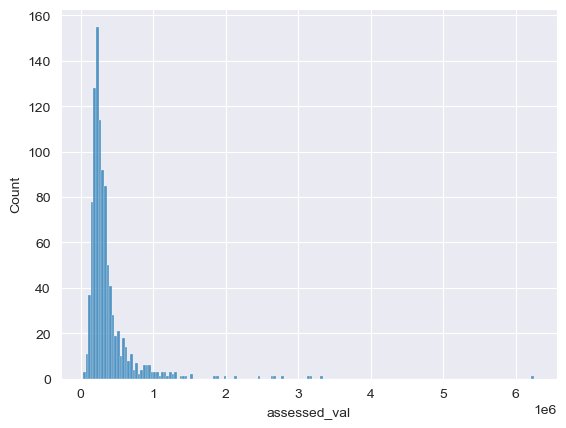

In [12]:
sns.histplot(data=sample_df, x="assessed_val")

<Axes: xlabel='assessed_val', ylabel='Count'>

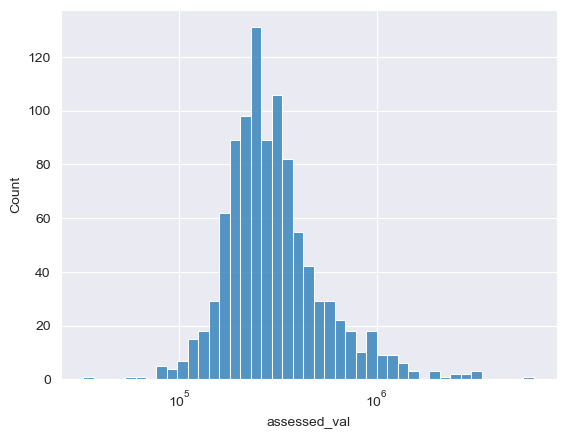

In [13]:
sns.histplot(data=sample_df, x="assessed_val", log_scale=True)

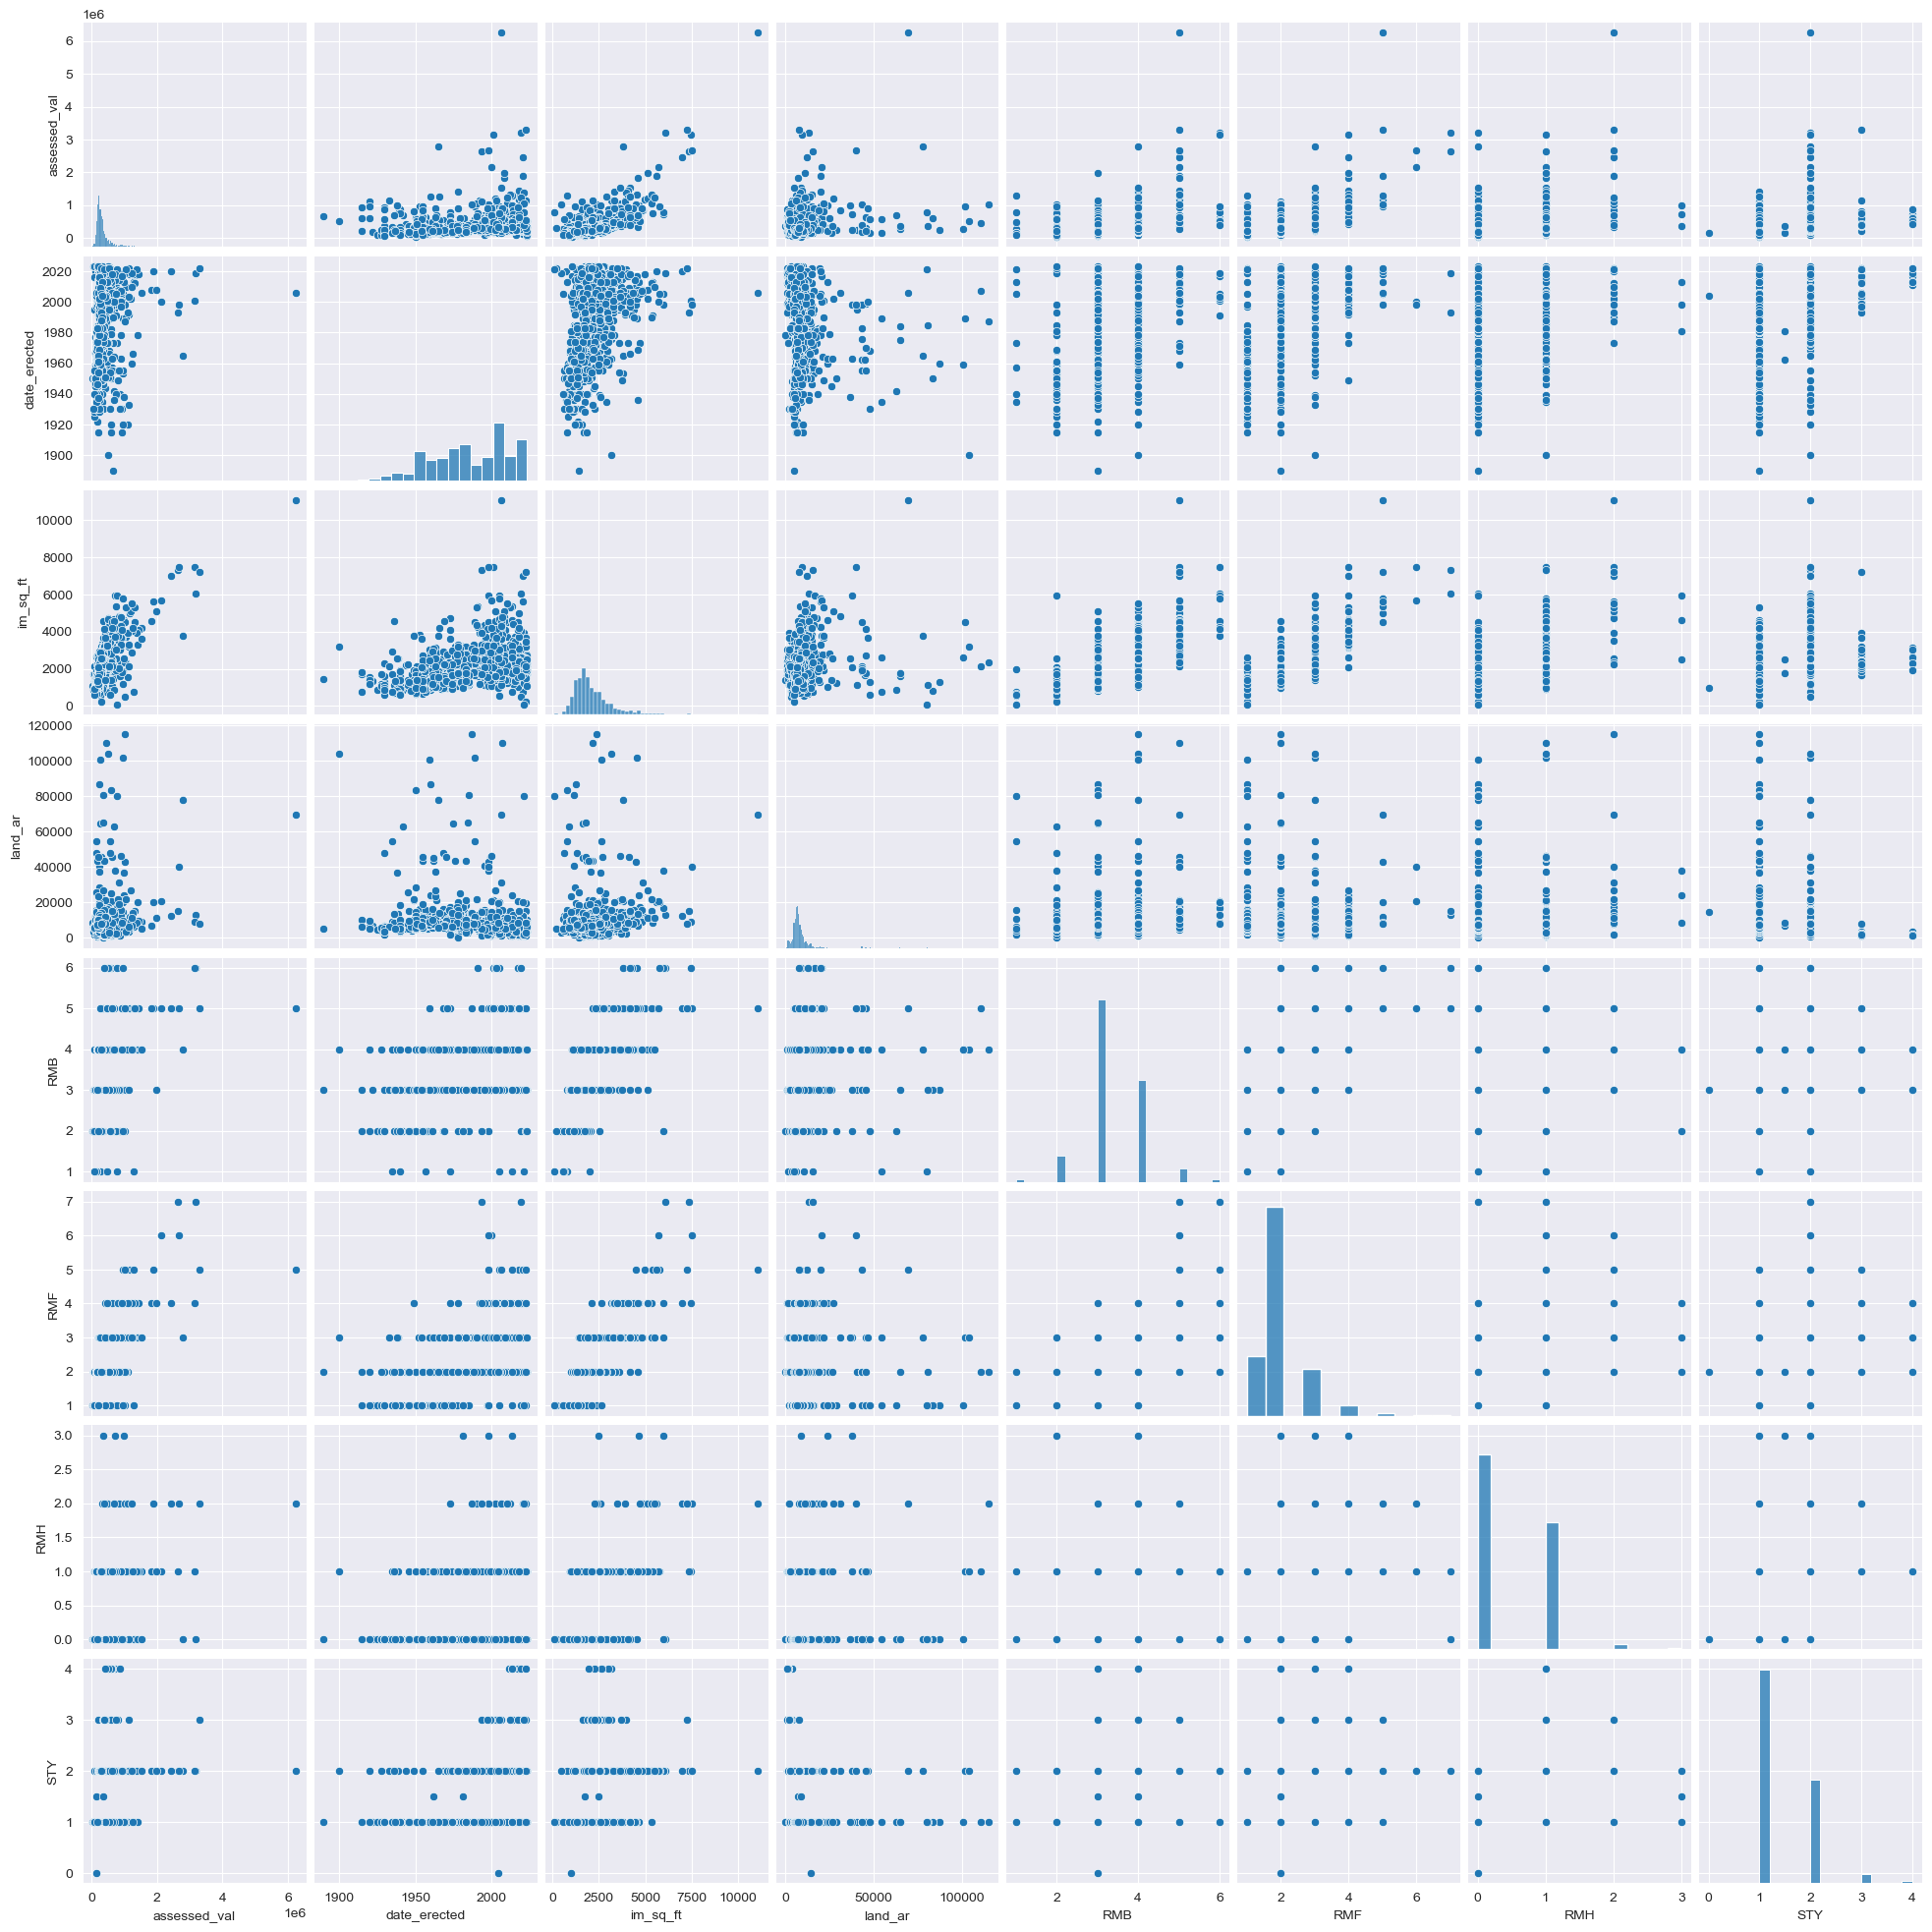

In [14]:
sns.pairplot(data=sample_df, vars=['assessed_val', 'date_erected', 'im_sq_ft', 'land_ar', 'RMB', 'RMF', 'RMH', 'STY'])

## Train, Test, Split!
The training and testing sets get split, but I will need to see some examples to see if there are indexes on the y's

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [31]:
model = ExtraTreesRegressor(n_estimators=500, random_state=42, n_jobs=-1, criterion='squared_error')

In [32]:
model_fit = model.fit(x_train, y_train)

In [34]:
cross_val_score(model_fit, x_train, y_train, cv=5, n_jobs=-1).mean()

0.5552992608282484

In [19]:
y_pred = model.predict(x_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

Mean Squared Error: 27241421306.80376


In [52]:
actual_df = y_test.copy()
actual_df.reset_index(inplace=True)
y_pred_df = pd.DataFrame(y_pred, columns=['pred'])
actual_df = pd.concat([actual_df, y_pred_df], axis=1, ignore_index=True)


TypeError: Cannot reset_index inplace on a Series to create a DataFrame

In [50]:
actual_df['y_pred'] = y_pred

In [25]:
param_grid = {
    'n_estimators': [250, 500, 750],
    'min_samples_leaf': [2, 5, 15, 25],
    'max_features': ["sqrt", "log2", 5, 10, 20],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}

In [26]:
etc2 = GridSearchCV(model_fit, param_grid, cv=3, n_jobs=-1)

In [27]:
etc2.fit(x_train, y_train)

C:\Users\Blake\miniconda3\envs\HouseProtestValues\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3, estimator=ExtraTreesRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'max_features': [5, 10, 20],
                         'min_samples_leaf': [2, 5, 15, 25],
                         'n_estimators': [250, 500, 750]})

In [28]:
etc2.best_params_

{'criterion': 'absolute_error',
 'max_features': 5,
 'min_samples_leaf': 2,
 'n_estimators': 750}

In [29]:
etc2.best_score_

0.6488253377798605